In [1]:
!ls

InitialConditioncreator.ipynb  sbi-logs
NN			       simulation_POC_1_param_prolif.ipynb
PhysiCell		       simulation_POC_adhesion_repulsion.ipynb
README.md		       simulation_POC_rules_prolif.ipynb
env			       simulator_3_pop_proportion.ipynb
ic_3D.py		       simulator_invasion.ipynb
inference.pkl		       simulator_leader_cell_path.ipynb
output.png		       simulatorwrap.ipynb
requirements.txt


In [2]:
import os
os.chdir("PhysiCell")

In [3]:
! ./project

Using config file ./config/PhysiCell_settings.xml ... 
Disabling automated spring adhesions and detachments!
1
dc? 1
User parameters in XML config file: 
Bool parameters:: 
normalize_ECM_influenced_motility_vector: 0 [dimensionless]
freeze_uE_profile: 0 [dimensionless]
enable_ecm_outputs: 1 [dimensionless]

Int parameters:: 
discrete_ECM_remodeling: 1 [dimensionless]
link_anisotropy_and_bias: 0 [dimensionless]
unit_test_setup: 0 [dimensionless]
march_unit_test_setup: 0 [dimensionless]

Double parameters:: 
initial_anisotropy: 0 [dimensionless]
initial_ECM_density: 0.5 [dimensionless]
chemotactic_substrate_decay_rate: 0.1 [1/minutes]
angle_of_chemical_field_gradient: 45 [dimensionless]
ECM_dx: 20 [um]
ECM_dy: 20 [um]
ECM_dz: 20 [um]
duration_of_uE_conditioning: 10 [minutes]

String parameters:: 
cell_setup: lesion [dimensionless]
chemical_field_setup: none [dimensionless]
ECM_orientation_setup: random [dimensionless]
cell_motility_ECM_interaction_model_selector: follower chemotaxis/no f

# MODIFIER LES SETTINGS

In [4]:
import xml.etree.ElementTree as ET

def modify_xml_value(file_path, tag_path, new_value):
    tree = ET.parse(file_path)
    root = tree.getroot()
    element = root
    for tag in tag_path:
        element = element.find(tag)
        if element is None:
            print(f"Balise '{tag}' non trouvée dans le chemin spécifié.")
            return False
    element.text = str(new_value)
    tree.write(file_path, encoding="utf-8", xml_declaration=True)
    return True

In [357]:
tag_path = ["overall", "max_time"]
new_value = 1440
modify_xml_value("config/PhysiCell_settings.xml", tag_path, new_value)
print("Fichier XML modifié avec succès.")

Fichier XML modifié avec succès.


In [362]:
# Exemple d'appel de la fonction pour modifier l'intervalle dans <SVG>
tag_path = ["save", "SVG", "interval"]
new_value = 200
modify_xml_value("config/PhysiCell_settings.xml", tag_path, new_value)
tag_path = ["save", "full_data", "interval"]
modify_xml_value("config/PhysiCell_settings.xml", tag_path, new_value)
print("Fichier XML modifié avec succès.")

Fichier XML modifié avec succès.


In [20]:
tag_path = ["cell_definitions", "cell_definition[@name='follower cell']", "phenotype","mechanics", "cell_cell_repulsion_strength"]
new_value = 90
modify_xml_value("config/PhysiCell_settings.xml", tag_path, new_value)
print("Fichier XML modifié avec succès.")

Fichier XML modifié avec succès.


In [26]:
tag_path = ["parallel", "omp_num_threads"]
new_value = 2
modify_xml_value("config/PhysiCell_settings.xml", tag_path, new_value)
print("Fichier XML modifié avec succès.")

Fichier XML modifié avec succès.


In [5]:
import time
import subprocess

start_time = time.time()

subprocess.run(["./project"] , stdout=subprocess.DEVNULL)

end_time = time.time()

execution_time = end_time - start_time

print(execution_time)

7.8591930866241455


In [11]:
import csv
def change_csv_value(csv_file_path, row_index, column_index, new_value):
    # Read the CSV file into a list of lists
    with open(csv_file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        data = list(reader)
    # Update the value of the specified cell
    if 0 <= row_index < len(data) and 0 <= column_index < len(data[row_index]):
        data[row_index][column_index] = str(new_value)

        # Save the modified data to the CSV file
        with open(csv_file_path, 'w', newline='') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerows(data)

    else:
        print(f"Invalid row index ({row_index}) or column index ({column_index})")


In [8]:
import numpy as np
import scipy.io
from math import sqrt
import subprocess
def get_count(path_mat):
    mat = scipy.io.loadmat(path_mat)
    id = mat['cells'][5]
    
    mask_id1 = (id == 1)


    # Count the number of cells that satisfy each mask
    count_id1 = np.count_nonzero(mask_id1)

    
    return count_id1
    #       follower cells, astrocytes, microglia + astro, microglia alone

get_count('/home/aymeric/tumor-simulation/PhysiCell/output/final_cells.mat')

249

In [15]:
agent_counts = []
num_timepoints = 9
for t in range(num_timepoints): 
    mat_filename = './output/output{0:08d}_cells.mat'.format(t)
    agent_count = get_count(mat_filename)
    agent_counts.append(agent_count)

print(torch.tensor(agent_counts))

tensor([135, 147, 156, 167, 179, 188, 212, 229, 248])


In [12]:
change_csv_value('./config/rules.csv', 0, 4, 1000) #rule oxy increase cycle entry saturation
change_csv_value('./config/rules.csv', 0, 5, 1000) #rule oxy increase cycle entry halfmax
change_csv_value('./config/rules.csv', 1, 4, 1000) #rule pressure decrease cycle entry saturation
change_csv_value('./config/rules.csv', 1, 5, 1000) #rule pressure decrease cycle entry halfmax

In [13]:
import torch
import pickle
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

/home/aymeric/tumor-simulation/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
def simulation_wrapper(params):
    if len(params.shape) == 1:
        n = 1
    else:
        n = params.shape[0]

    results = []
    
    #print(n)
    
    for i in range(n):
        if n == 1:
            param1 = params[0]
            param2 = params[1]
            #param3 = params[2]
            #param4 = params[3]

            
        else:
            param1 = params[i, 0]
            param2 = params[i, 1]
            #param3 = params[i, 2]
            #param4 = params[i, 3]

            
    
        
        change_csv_value('./config/rules.csv', 0, 4, param1.item()) #rule oxy increase cycle entry saturation
        change_csv_value('./config/rules.csv', 0, 5, param2.item()) #rule oxy increase cycle entry halfmax
        #change_csv_value('./config/rules.csv', 1, 4, param3.item()) #rule pressure decrease cycle entry saturation
        #change_csv_value('./config/rules.csv', 1, 5, param4.item()) #rule pressure decrease cycle entry halfmax

        subprocess.run(["./project"] , stdout=subprocess.DEVNULL)

        agent_counts = []
        num_timepoints = 9
        for t in range(num_timepoints): 
            mat_filename = './output/output{0:08d}_cells.mat'.format(t)
            agent_count = get_count(mat_filename)
            agent_counts.append(agent_count)
        

    #results.append(torch.tensor(pos))
    
    #for x in results:
        results.append(torch.tensor(agent_counts))
    results = torch.cat(results)

    return results.flatten()


In [25]:
simulation_wrapper(torch.tensor([[0.0007, 21.5, 0, 1],[0.0002, 21.5, 0, 1]]))

tensor([135, 150, 155, 171, 192, 209, 226, 246, 266, 135, 142, 147, 149, 148,
        153, 157, 166, 169])

In [30]:
num_dim = 2
low = torch.tensor([0, 10])

# Définir les bornes supérieures pour chaque dimension
high = torch.tensor([0.002, 30])

# Créer le prior uniforme avec les bornes spécifiées
prior = utils.BoxUniform(low=low, high=high)

In [31]:
simulator, prior = prepare_for_sbi(simulation_wrapper, prior)

In [32]:
inference = SNPE(prior=prior)

In [34]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=200)

Running 200 simulations.:  88%|████████▊ | 175/200 [1:10:31<11:12, 26.89s/it]

In [78]:
inference = inference.append_simulations(theta, x)

In [79]:
density_estimator = inference.train()

 Neural network successfully converged after 97 epochs.

In [102]:
with open("/home/aymeric/tumor-simulation/NN/leader/simulated_data1000.pkl", "wb") as handle:
    pickle.dump((theta, x), handle)
with open("/home/aymeric/tumor-simulation/NN/leader/density_estimator1000.pkl", "wb") as handle:
    pickle.dump(density_estimator, handle)

In [80]:
posterior = inference.build_posterior(density_estimator)

In [81]:
theta = torch.tensor([0.5, 0.5, 0.05, 10, 1.25])
x_o = simulation_wrapper(theta)
print(x_o)

tensor([0.0000e+00, 0.0000e+00, 1.0000e+01, 4.2441e-03, 2.0000e+01, 4.4563e-03,
        3.0000e+01, 5.0020e-03, 4.0000e+01, 3.1831e-03, 5.0000e+01, 3.1831e-03,
        6.0000e+01, 3.9177e-03, 7.0000e+01, 2.7587e-03, 8.0000e+01, 3.5576e-03,
        9.0000e+01, 2.1779e-03, 1.0000e+02, 1.9705e-03, 1.1000e+02, 1.7991e-03,
        1.2000e+02, 1.5279e-03, 1.3000e+02, 1.6505e-03, 1.4000e+02, 1.5367e-03,
        1.5000e+02, 9.2413e-04, 1.6000e+02, 5.7875e-04, 1.7000e+02, 1.8189e-04,
        1.8000e+02, 6.0221e-04, 1.9000e+02, 4.0809e-04, 2.0000e+02, 1.5527e-04,
        2.1000e+02, 2.9610e-04, 2.2000e+02, 0.0000e+00, 2.3000e+02, 6.7726e-05,
        2.4000e+02, 0.0000e+00, 2.5000e+02, 0.0000e+00, 2.6000e+02, 0.0000e+00,
        2.7000e+02, 0.0000e+00, 2.8000e+02, 5.5844e-05, 2.9000e+02, 0.0000e+00,
        3.0000e+02, 0.0000e+00, 3.1000e+02, 0.0000e+00, 3.2000e+02, 0.0000e+00,
        3.3000e+02, 0.0000e+00, 3.4000e+02, 0.0000e+00, 3.5000e+02, 0.0000e+00,
        3.6000e+02, 0.0000e+00, 3.7000e+

tensor([0.0000e+00, 0.0000e+00, 1.0000e+01, 4.2441e-03, 2.0000e+01, 4.4563e-03,
        3.0000e+01, 5.0020e-03, 4.0000e+01, 3.1831e-03, 5.0000e+01, 3.1831e-03,
        6.0000e+01, 3.9177e-03, 7.0000e+01, 2.7587e-03, 8.0000e+01, 3.5576e-03,
        9.0000e+01, 2.1779e-03, 1.0000e+02, 1.9705e-03, 1.1000e+02, 1.7991e-03,
        1.2000e+02, 1.5279e-03, 1.3000e+02, 1.6505e-03, 1.4000e+02, 1.5367e-03,
        1.5000e+02, 9.2413e-04, 1.6000e+02, 5.7875e-04, 1.7000e+02, 1.8189e-04,
        1.8000e+02, 6.0221e-04, 1.9000e+02, 4.0809e-04, 2.0000e+02, 1.5527e-04,
        2.1000e+02, 2.9610e-04, 2.2000e+02, 0.0000e+00, 2.3000e+02, 6.7726e-05,
        2.4000e+02, 0.0000e+00, 2.5000e+02, 0.0000e+00, 2.6000e+02, 0.0000e+00,
        2.7000e+02, 0.0000e+00, 2.8000e+02, 5.5844e-05, 2.9000e+02, 0.0000e+00,
        3.0000e+02, 0.0000e+00, 3.1000e+02, 0.0000e+00, 3.2000e+02, 0.0000e+00,
        3.3000e+02, 0.0000e+00, 3.4000e+02, 0.0000e+00, 3.5000e+02, 0.0000e+00,
        3.6000e+02, 0.0000e+00, 3.7000e+

Drawing 10000 posterior samples: 10036it [00:01, 6817.96it/s]                          


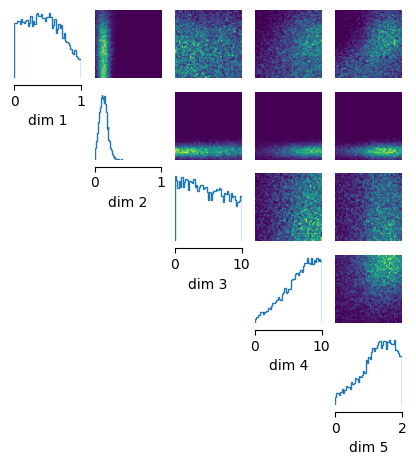

In [84]:
print(x_o)
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[0, 1], [0, 1], [0, 10], [0, 10], [0, 2]], figsize=(5, 5)
)


In [87]:
import numpy as np

def calculate_mse(list1, list2):
    """Calculer l'erreur quadratique moyenne entre deux listes."""
    return np.mean((np.array(list1) - np.array(list2)) ** 2)

def calculate_nmse(list1, list2):
    """Calculer l'erreur quadratique moyenne normalisée."""
    mse = calculate_mse(list1, list2)
    variance = np.var(list1)
    return mse / variance if variance != 0 else float('inf')

def calculate_relative_mse(list1, list2):
    """Calculer l'erreur quadratique relative."""
    mse = calculate_mse(list1, list2)
    mean1 = np.mean(list1)
    mean2 = np.mean(list2)
    relative_mse = mse / ((mean1 + mean2) / 2)
    return relative_mse

def calculate_mae(list1, list2):
    """Calculer l'erreur absolue moyenne entre deux listes."""
    return np.mean(np.abs(np.array(list1) - np.array(list2)))

def calculate_log_mse(list1, list2):
    """Calculer le logarithme de l'erreur quadratique moyenne."""
    mse = calculate_mse(list1, list2)
    return np.log(mse + 1e-10)  # Éviter log(0) avec une petite constante




In [ ]:
print(posterior_samples.median(dim=0).values)
predicted_tensor = simulation_wrapper(posterior_samples.median(dim=0).values)
print(predicted_tensor)


In [91]:

# Exemples de listes
list1 = x_o.numpy()
list2 = predicted_tensor.numpy()

# Calcul des différentes métriques
mse = calculate_mse(list1, list2)
nmse = calculate_nmse(list1, list2)
relative_mse = calculate_relative_mse(list1, list2)
mae = calculate_mae(list1, list2)
log_mse = calculate_log_mse(list1, list2)

# Affichage des résultats
print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur quadratique moyenne normalisée (NMSE) : {nmse}")
print(f"Erreur quadratique relative : {relative_mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")
print(f"Logarithme de l'erreur quadratique moyenne (Log MSE) : {log_mse}")

Erreur quadratique moyenne (MSE) : 6.897770322052374e-07
Erreur quadratique moyenne normalisée (NMSE) : 2.7136661070825822e-11
Erreur quadratique relative : 5.630809545638348e-09
Erreur absolue moyenne (MAE) : 0.00029640884319991686
Logarithme de l'erreur quadratique moyenne (Log MSE) : -14.18675246943245
